In [1]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xarray as xr

import bambi as bmb
from bambi.plots import plot_comparison

%load_ext autoreload
%autoreload 2

### mtcars

In [2]:
# Load data
data = bmb.load_data('mtcars')
data["cyl"] = data["cyl"].replace({4: "low", 6: "medium", 8: "high"})
data["gear"] = data["gear"].replace({3: "A", 4: "B", 5: "C"})
data["cyl"] = pd.Categorical(data["cyl"], categories=["low", "medium", "high"], ordered=True)
data["am"] = pd.Categorical(data["am"], categories=[0, 1], ordered=True)

In [3]:
# Define and fit the Bambi model
mt_model = bmb.Model("mpg ~ hp * drat * am", data)
mt_idata = mt_model.fit(draws=1000, target_accept=0.95, random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mpg_sigma, Intercept, hp, drat, hp:drat, am, hp:am, drat:am, hp:drat:am]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 70 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [4]:
df_comparison, idata_comparison = plot_comparison(
    mt_model,
    mt_idata,
    contrast_predictor="hp",
    conditional=["am", "drat"]
)

In [5]:
idx_146 = (df_comparison["hp"] == 146).to_numpy()
idx_147 = (df_comparison["hp"] == 147).to_numpy()

draws_146 = idata_comparison.posterior["mpg_mean"].sel(mpg_obs=idx_146)
draws_147 = idata_comparison.posterior["mpg_mean"].sel(mpg_obs=idx_147)

In [6]:
# We need to change the values of the coords otherwise xarray will see them as different
# We could find a more elegant solution that modifies the coords before splitting into 
# draws_146 and draws_147 but first i want to make sure this approach works
draws_146 = draws_146.assign_coords({"mpg_obs": np.arange(len(draws_146.coords["mpg_obs"]))})
draws_147 = draws_147.assign_coords({"mpg_obs": np.arange(len(draws_147.coords["mpg_obs"]))})

I imagine we will need

* A sequence with all the values of the contrast values
    * Example: `(146, 147, 148, 149)`
* A sequence with all the combinations of two
    * Example: `[(146, 147), (146, 148), (146, 149), (147, 148), (147, 149), (148, 149)]`
    * It's the result of: `list(itertools.combinations((146, 147, 148, 149), 2))`
* Something that iterates through the elements of the list with all the combinations, indexes the DataArray to create two objects as above, computes the operation, and the mean and bounds.

In [7]:
functions = {
    "diff": lambda x, y: x - y,
    "ratio": lambda x, y: x / y

}
function = functions["diff"]
diff_draws = function(draws_146, draws_147)

In [8]:
mean = diff_draws.mean(("chain", "draw")).to_numpy()
lower, upper = diff_draws.quantile((0.025, 0.975), ("chain", "draw")).to_numpy()

In [9]:
df_comparison = df_comparison.drop_duplicates(["am", "drat"]).reset_index(drop=True)
df_comparison["mean"] = mean
df_comparison["lower"] = lower
df_comparison["upper"] = upper
df_comparison

,am,drat,hp,mean,lower,upper
0,0,2.760,146,0.046826,0.007413,0.085667
1,0,3.080,146,0.050254,0.020831,0.081152
2,0,3.695,146,0.056842,0.021767,0.088795
3,0,3.920,146,0.059253,0.017106,0.097671
4,0,4.930,146,0.070073,-0.012537,0.151459
5,1,2.760,146,0.028468,-0.026985,0.087123
6,1,3.080,146,0.036495,-0.005089,0.080334
7,1,3.695,146,0.051922,0.027215,0.076419
8,1,3.920,146,0.057566,0.032025,0.082211
9,1,4.930,146,0.082901,0.017209,0.140309


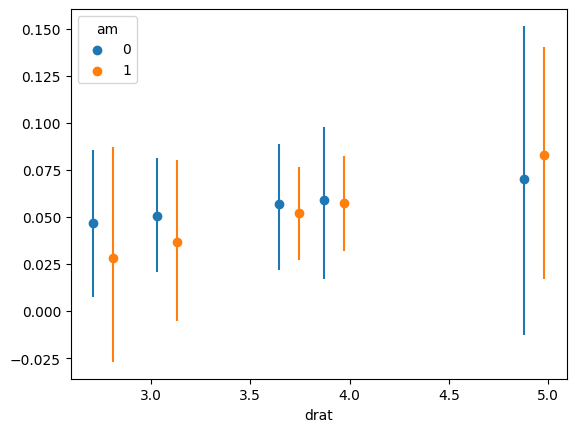

In [10]:
offset = [-0.05, 0.05]

fig, ax = plt.subplots()

# I'm changing the order of the conditional covariates
for i, (am, dfg) in enumerate(df_comparison.groupby("am")):
    ax.scatter(dfg["drat"] + offset[i] , dfg["mean"], label=am)
    ax.vlines(dfg["drat"] + offset[i], dfg["lower"], dfg["upper"], color=f"C{i}")

ax.legend(title="am", loc="upper left")
ax.set(xlabel="drat");

**Below is the current approach**

In [1]:
# HDI does not include the mean contrast comparison...
fig, ax, comparisons_df, contrast_df, idata_new = plot_comparison(
    mt_model,
    mt_idata,
    contrast_predictor="hp",
    conditional=["am", "drat"]
)
fig.set_size_inches(7, 3)
plt.title("Difference in mpg between am and drat\nfor hp contrast [110, 175]");

NameError: name 'plot_comparison' is not defined

In [5]:
contrast_df

,estimate,hdi_3%,hdi_97%,term,contrast,am,drat
0,-0.046826,-0.019494,-0.045578,hp,"[146, 147]",0,2.760
1,-0.050254,-0.046580,-0.070765,hp,"[146, 147]",0,3.080
2,-0.056842,-0.114109,-0.110300,hp,"[146, 147]",0,3.695
3,-0.059253,-0.084117,-0.059249,hp,"[146, 147]",0,3.920
4,-0.070073,0.070029,0.095326,hp,"[146, 147]",0,4.930
5,-0.028468,-0.022729,-0.029369,hp,"[146, 147]",1,2.760
6,-0.036495,-0.013404,-0.037834,hp,"[146, 147]",1,3.080
7,-0.051922,-0.090531,-0.076939,hp,"[146, 147]",1,3.695
8,-0.057566,-0.045938,-0.032218,hp,"[146, 147]",1,3.920
9,-0.082901,-0.180633,-0.118730,hp,"[146, 147]",1,4.930


### Using xarray

For computing comparisons of posterior samples

In [7]:
compare_xr = comparisons_df.iloc[:, :3].to_xarray().to_array().T

If we select only one chain and draw, then we can create an xarray Dataset with the posterior samples and data used for performing predictions.

In [19]:
compare_DS = xr.Dataset(
    # can't do this because shape is not consistent with coords
    # {
    #     "mpg_preds": (["preds"], idata_new.posterior.mpg_mean.sel(chain=0, draw=0).values)
    # },
    {
        "mpg_preds": (["preds"], idata_new.posterior.mpg_mean.values)
    },
    coords={
        "drat": (["drat"], drat),
        "am": (["am"], am),
        "hp": (["hp"], hp),
    }
# cant do this because the group by would not take into account the group levels of each covariate?
#     coords={
#         "covariates": (["drat", "am", "hp"], comparisons_df.iloc[:, :3].values)
#     }
)

ValueError: Could not convert tuple of form (dims, data[, attrs, encoding]): (['preds'], array([[[19.59478712, 19.54856056, 19.23140441, ..., 22.49626788,
         22.51163257, 22.44590673],
        [18.27013994, 18.22625734, 18.58204345, ..., 23.3491659 ,
         19.44539658, 19.35357745],
        [18.85953525, 18.81616193, 18.31847112, ..., 23.20774708,
         22.53151746, 22.45055377],
        ...,
        [16.95947443, 16.91816056, 17.61175804, ..., 22.68251523,
         22.94911059, 22.84984865],
        [16.75874405, 16.71122187, 17.75769402, ..., 23.31604767,
         24.31327371, 24.22783439],
        [15.98276926, 15.93614123, 16.72108478, ..., 21.95560998,
         17.56669211, 17.48011585]],

       [[15.13806506, 15.07475069, 16.57548916, ..., 22.93274638,
         21.45973418, 21.40293702],
        [14.03187854, 13.96100312, 15.45925062, ..., 23.96888318,
         18.56936995, 18.5055643 ],
        [15.43032887, 15.38152436, 15.72765387, ..., 24.00778199,
         31.43343708, 31.39218212],
        ...,
        [15.46060449, 15.44254019, 16.22415641, ..., 22.5952011 ,
         22.00937089, 21.92098704],
        [15.93206177, 15.91515816, 16.90845999, ..., 22.31407781,
         25.07906851, 24.98810065],
        [15.49355372, 15.45764709, 17.06462284, ..., 23.43403333,
         20.42975062, 20.34075804]],

       [[16.32471939, 16.30094022, 17.43097525, ..., 23.00163648,
         26.80332891, 26.72146453],
        [17.33521783, 17.3134523 , 17.95562079, ..., 23.03445699,
         21.59493384, 21.51720511],
        [17.54063129, 17.49845413, 17.65990214, ..., 22.36994524,
         27.4844157 , 27.42609916],
        ...,
        [16.01830855, 15.99339059, 16.59490184, ..., 22.48199671,
         27.81130108, 27.72439551],
        [17.4080136 , 17.34345667, 17.8184839 , ..., 22.84697905,
         23.71841269, 23.66731893],
        [16.42590678, 16.38630959, 17.46862252, ..., 22.37950074,
         22.93086901, 22.83010099]],

       [[14.73567007, 14.71271276, 16.69253713, ..., 23.71015323,
         27.15856241, 27.08063007],
        [12.98946737, 12.96790069, 14.86294855, ..., 23.11624176,
         28.56426266, 28.53871872],
        [18.6172853 , 18.59698247, 17.67934574, ..., 22.3743203 ,
         21.99053511, 21.91634019],
        ...,
        [17.82254531, 17.77186059, 17.60227204, ..., 22.91981166,
         26.42983377, 26.39747279],
        [16.01207202, 15.96297043, 17.00412761, ..., 24.1316353 ,
         16.16548566, 16.05931968],
        [16.35202156, 16.29547816, 17.84546165, ..., 23.57569998,
         25.46476917, 25.40356825]]])) to Variable.

### Using Pandas

Since posterior is shape (4, 1000, 20) where 20 is the row number of the data used for prediction, we can create a DataFrame `posterior_with_obs` with the posterior samples and data used for performing predictions.

In [31]:
comparisons_df.index.name = "mpg_obs"
comparisons_df = comparisons_df.iloc[:, :3].reset_index()

idata_df = idata_new.posterior.mpg_mean.to_dataframe().reset_index()

posterior_with_obs = pd.merge(
    idata_df,
    comparisons_df,
    how="left",
    on="mpg_obs"
)

posterior_with_obs

,chain,draw,mpg_obs,mpg_mean,am,drat,hp
0,0,0,0,19.594787,0,2.760,146
1,0,0,1,19.548561,0,2.760,147
2,0,0,2,19.231404,0,3.080,146
3,0,0,3,19.175185,0,3.080,147
4,0,0,4,18.533028,0,3.695,146
...,...,...,...,...,...,...,...
79995,3,999,15,23.168502,1,3.695,147
79996,3,999,16,23.633115,1,3.920,146
79997,3,999,17,23.575700,1,3.920,147
79998,3,999,18,25.464769,1,4.930,146


array([-2.90745548,  2.81403525])

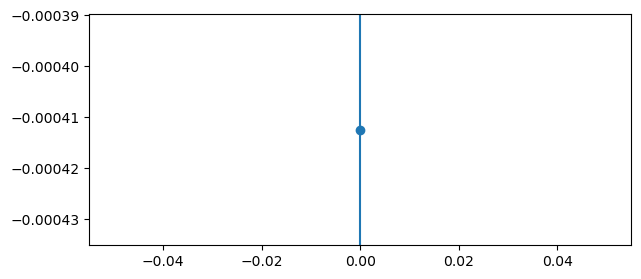

In [24]:
# only look at am=0 and drat=2.76
# not showing entire vline for some reason
diffs = posterior_with_obs.query("am == 0 and drat == 2.760")["mpg_mean"].diff().dropna().reset_index(drop=True)
mean_diff = diffs.mean()
hdi = az.hdi(diffs.to_numpy(), hdi_prob=0.94)

plt.figure(figsize=(7, 3))
plt.scatter(0, mean_diff)
plt.axvline(0, hdi[0], hdi[1])
hdi

In [27]:
posterior_with_obs

,chain,draw,mpg_obs,mpg_mean,am,drat,hp
0,0,0,0,19.594787,0,2.760,146
1,0,0,1,19.548561,0,2.760,147
2,0,0,2,19.231404,0,3.080,146
3,0,0,3,19.175185,0,3.080,147
4,0,0,4,18.533028,0,3.695,146
...,...,...,...,...,...,...,...
79995,3,999,15,23.168502,1,3.695,147
79996,3,999,16,23.633115,1,3.920,146
79997,3,999,17,23.575700,1,3.920,147
79998,3,999,18,25.464769,1,4.930,146


In [43]:
posterior_diff = pd.DataFrame((posterior_with_obs
 .groupby(["am", "drat", "chain", "draw"])["mpg_mean"]
 .diff()
 #.dropna()
 .reset_index(drop=True)
 )).rename(columns={"mpg_mean": "mpg_diff"})

posterior_diff_obs = pd.concat([posterior_diff, posterior_with_obs], axis=1).dropna(axis=0, how="any")

posterior_diff_mean = pd.DataFrame((posterior_diff_obs[["mpg_diff", "chain", "draw", "mpg_obs"]]
 .groupby(["mpg_obs"])["mpg_diff"]
 .mean()
 .reset_index(drop=True)
))

posterior_diff_std = pd.DataFrame((posterior_diff_obs[["mpg_diff", "chain", "draw", "mpg_obs"]]
 .groupby(["mpg_obs"])["mpg_diff"]
 .std()
 .reset_index(drop=True)
))

In [25]:
# posterior_diff = pd.DataFrame((posterior_with_obs
#  .groupby(["am", "drat"])["mpg_mean"]
#  .diff()
#  #.dropna()
#  .reset_index(drop=True)
#  )).rename(columns={"mpg_mean": "mpg_diff"})

# posterior_diff_obs = pd.concat([posterior_diff, posterior_with_obs], axis=1).dropna(axis=0, how="any")

# posterior_diff_mean = pd.DataFrame((posterior_diff_obs[["mpg_diff", "chain", "draw", "mpg_obs"]]
#  .groupby(["mpg_obs"])["mpg_diff"]
#  .mean()
#  .reset_index(drop=True)
# ))

# posterior_diff_std = pd.DataFrame((posterior_diff_obs[["mpg_diff", "chain", "draw", "mpg_obs"]]
#  .groupby(["mpg_obs"])["mpg_diff"]
#  .std()
#  .reset_index(drop=True)
# ))

In [47]:
contrast_df["estimate_full"] = posterior_diff_mean["mpg_diff"]
contrast_df["std_full_lower"] = posterior_diff_mean["mpg_diff"] - posterior_diff_std["mpg_diff"]
contrast_df["std_full_higher"] = posterior_diff_mean["mpg_diff"] + posterior_diff_std["mpg_diff"]

In [48]:
contrast_df

,estimate,hdi_3%,hdi_97%,term,contrast,am,drat,estimate_full,std_full_lower,std_full_higher
0,-0.046206,-0.003756,-0.026338,hp,"[146, 147]",0,2.760,-0.046206,-0.066607,-0.025805
1,-0.049976,-0.037245,-0.056671,hp,"[146, 147]",0,3.080,-0.049976,-0.065686,-0.034266
2,-0.057222,-0.047034,-0.031519,hp,"[146, 147]",0,3.695,-0.057222,-0.073846,-0.040598
3,-0.059873,-0.119706,-0.104732,hp,"[146, 147]",0,3.920,-0.059873,-0.079970,-0.039775
4,-0.071772,-0.142725,-0.086004,hp,"[146, 147]",0,4.930,-0.071772,-0.113567,-0.029977
5,-0.028507,-0.001350,0.017412,hp,"[146, 147]",1,2.760,-0.028507,-0.057614,0.000601
6,-0.036580,-0.014789,-0.020630,hp,"[146, 147]",1,3.080,-0.036580,-0.058501,-0.014660
7,-0.052097,-0.038705,-0.045089,hp,"[146, 147]",1,3.695,-0.052097,-0.064127,-0.040067
8,-0.057774,-0.207495,-0.198384,hp,"[146, 147]",1,3.920,-0.057774,-0.069740,-0.045809
9,-0.083257,-0.148901,-0.072400,hp,"[146, 147]",1,4.930,-0.083257,-0.113862,-0.052652


In [68]:
drat_unique = contrast_df["drat"].unique()
main_levels = len(drat_unique)
idx_main = np.arange(main_levels)

In [75]:
vals = contrast_df[["std_full_lower", "std_full_higher"]].values

In [76]:
# interval contains mean estimate
contrast_df

,estimate,hdi_3%,hdi_97%,term,contrast,am,drat,estimate_full,std_full_lower,std_full_higher
0,-0.046206,-0.003756,-0.026338,hp,"[146, 147]",0,2.760,-0.046206,-0.066607,-0.025805
1,-0.049976,-0.037245,-0.056671,hp,"[146, 147]",0,3.080,-0.049976,-0.065686,-0.034266
2,-0.057222,-0.047034,-0.031519,hp,"[146, 147]",0,3.695,-0.057222,-0.073846,-0.040598
3,-0.059873,-0.119706,-0.104732,hp,"[146, 147]",0,3.920,-0.059873,-0.079970,-0.039775
4,-0.071772,-0.142725,-0.086004,hp,"[146, 147]",0,4.930,-0.071772,-0.113567,-0.029977
5,-0.028507,-0.001350,0.017412,hp,"[146, 147]",1,2.760,-0.028507,-0.057614,0.000601
6,-0.036580,-0.014789,-0.020630,hp,"[146, 147]",1,3.080,-0.036580,-0.058501,-0.014660
7,-0.052097,-0.038705,-0.045089,hp,"[146, 147]",1,3.695,-0.052097,-0.064127,-0.040067
8,-0.057774,-0.207495,-0.198384,hp,"[146, 147]",1,3.920,-0.057774,-0.069740,-0.045809
9,-0.083257,-0.148901,-0.072400,hp,"[146, 147]",1,4.930,-0.083257,-0.113862,-0.052652


In [ ]:
import seaborn.objects as so

(
    so.Plot(contrast_df, x="am", y="estimate_full", color="drat")
    .add(so.Range(), so.Dodge())
    .add(so.Dot(), so.Agg(), so.Dodge())
)

#plt.axvline(0, vals[:, 0], vals[:, 1])


Why are the vlines showing like this? Looking at the df above, the estimate_full is always within the lower and higher interval.....

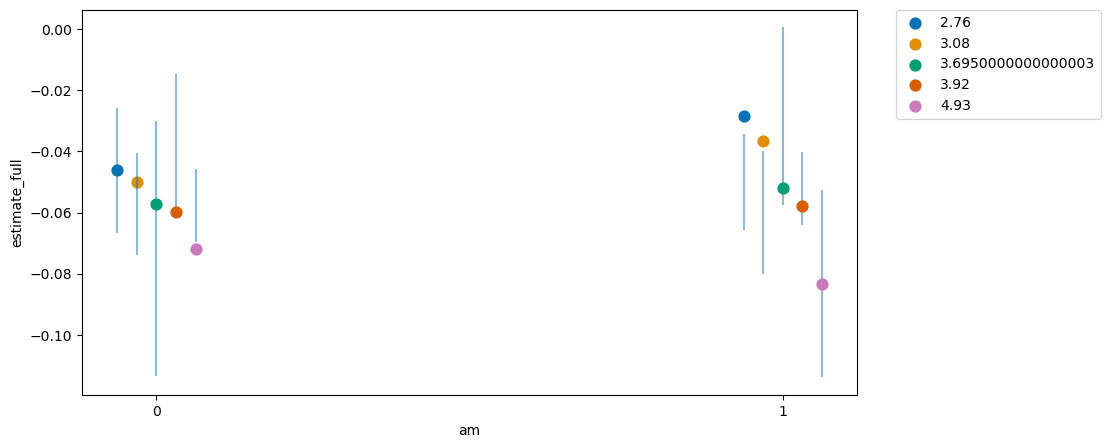

In [114]:
plt.figure(figsize=(10, 5))
ax = sns.pointplot(
    data=contrast_df,
    x="am",
    y="estimate_full",
    hue="drat",
    dodge=True,
    join=False,
    palette="colorblind"
)

x_coords = []
y_coords = []
for point_pair in ax.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)

plt.vlines(x_coords, contrast_df["std_full_lower"], contrast_df["std_full_higher"], alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);